In [273]:
import numpy as np
import librosa
import librosa.display
import itertools
import os
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization


<class 'numpy.ndarray'> <class 'int'>


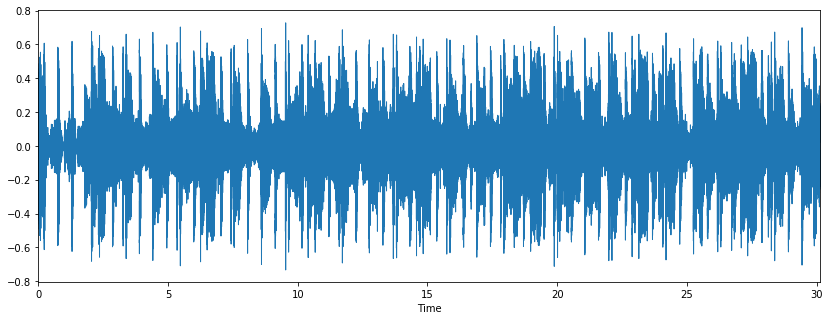

In [276]:
#First, we'll use each audio file's spectrogram to train a CNN and see if we can achieve decent accuracy.
#Let's visualize some songs:

sample_path = '/Users/jadhamdan/Desktop/Final Project/genres dataset/genres/disco/disco.00000.au/'
sample, sr = librosa.load(sample_path)
print(type(sample), type(sr))

plt.figure(figsize=(14,5))
librosa.display.waveplot(sample, sr=sr)

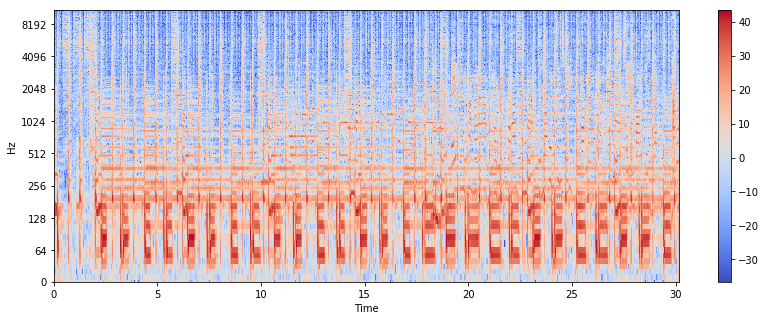

In [279]:
SAMPLE = librosa.stft(sample)
SAMPLEdb = librosa.amplitude_to_db(abs(SAMPLE))
plt.figure(figsize=(14,5))
librosa.display.specshow(SAMPLEdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [293]:
def melspectro(songs, n_fft = 1024, hop_length=512):
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft,
                                                      hop_length = hop_length)[:,:,np.newaxis]
    
    transformed = map(melspec, songs)
    return np.array(list(transformed))


def to_dataset(X, y, window = 0.1,overlap = 0.5):
    temp_one = []
    temp_two = []
    chunk = int(X.shape[0]*window)
    offset = int(chunk*(1.-overlap))
    array = [X[i:i+chunk] for i in range(0, X.shape[0] - chunk + offset, offset)]
    for s in array:
        temp_one.append(s)
        temp_two.append(y)
    return np.array(temp_one), np.array(temp_two)

source = '/Users/jadhamdan/Desktop/Final Project/genres dataset/genres/'
X = []
y = []
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
        'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
for x,_ in genres.items():
    folder = source + x

    for root, subdirs, files in os.walk(folder):
        for file in files:
            file_name = folder + "/" + file
            sg, sr = librosa.load(file_name)
            sg = sg[:660000]

            songs, labels = to_dataset(sg, genres[x])
            
            spectrograms = melspectro(songs)
            
            y.extend(labels)
            X.extend(spectrograms)

In [295]:
X = np.array(X)
y = np.array(y)
y = to_categorical(y)

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [297]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13300, 128, 129, 1) (5700, 128, 129, 1) (13300, 10) (5700, 10)


In [298]:
input_shape = X_train[0].shape
model = Sequential()
model.add(Conv2D(10, kernel_size=(3,3), strides=(1,1),
                 activation='relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(Conv2D(20, kernel_size=(3,3), strides=(1,1),
                 activation='relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(Conv2D(40, kernel_size=(3,3), strides=(1,1),
                 activation='relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(Conv2D(80, kernel_size=(3,3), strides=(1,1),
                 activation='relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 127, 10)      100       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 10)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 20)        1820      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 40)        7240      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 40)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 80)        28880     
__________

In [299]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])
hist = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data = (X_test, y_test))

Train on 13300 samples, validate on 5700 samples
Epoch 1/10
13300/13300 [==============================] - 108s 8ms/step - loss: 1.7373 - acc: 0.4031 - val_loss: 1.3601 - val_acc: 0.5279
Epoch 2/10
13300/13300 [==============================] - 92s 7ms/step - loss: 1.2327 - acc: 0.5804 - val_loss: 1.1177 - val_acc: 0.6258
Epoch 3/10
13300/13300 [==============================] - 80s 6ms/step - loss: 0.9962 - acc: 0.6732 - val_loss: 1.0047 - val_acc: 0.6681
Epoch 4/10
13300/13300 [==============================] - 80s 6ms/step - loss: 0.8200 - acc: 0.7307 - val_loss: 0.8751 - val_acc: 0.7179
Epoch 5/10
13300/13300 [==============================] - 81s 6ms/step - loss: 0.6839 - acc: 0.7750 - val_loss: 0.8452 - val_acc: 0.7321
Epoch 6/10
13300/13300 [==============================] - 83s 6ms/step - loss: 0.5679 - acc: 0.8151 - val_loss: 0.9805 - val_acc: 0.7128
Epoch 7/10
13300/13300 [==============================] - 82s 6ms/step - loss: 0.5073 - acc: 0.8372 - val_loss: 0.9243 - val_acc

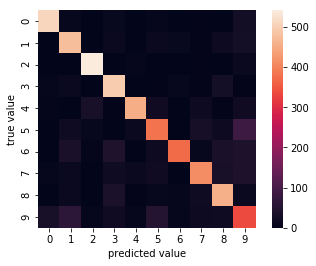

In [308]:
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis = 1)
y_true = np.argmax(y_test, axis = 1)
mat = confusion_matrix(y_true, y_pred)

sns.heatmap(mat, square=True, annot=False, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');
plt.show()

model.save('/Users/jadhamdan/Desktop/Final Project/genres dataset/cnn.h5')